<a href="https://colab.research.google.com/github/Will170393/MSc-Project---Stance-Detection/blob/master/4_msc_project_tfidf_glove_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing libraries**

In [0]:
# libraries for processing data
import numpy as np
import pandas as pd
import re

# libraries for loading files from drive
from google.colab import drive
drive.mount('/content/gdrive')

# libraries for natural language processing
from nltk import FreqDist, word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import wordnet
nltk.download('wordnet')

# sklearn libraries for manipulating vectors and results analysis
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# neural network libraries
import tensorflow as tf
from keras import regularizers
from keras.layers import Dense
from keras.models import Model, Sequential
from keras.layers import Dropout, Activation
from keras.utils.np_utils import to_categorical

from matplotlib import pyplot as plt

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Using TensorFlow backend.


**Reading data into panda dataframes and merging Stances and Bodies**

In [0]:
# creates dataframes from reading the stance and body csv files from the google drive, train/test set already split
trainStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_stances.csv')
trainBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/train_bodies.csv')
testStances = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_stances.csv')
testBodies = pd.read_csv('gdrive/My Drive/Colab Notebooks/MSC_project_data/competition_test_bodies.csv')

In [0]:
# merges dataframes for article bodies and article stances, inner merge on the Body ID column that appears in both dataframes
def mergeStances_Bodies(stances, bodies):
  return pd.merge(stances, bodies, how='inner', on='Body ID')

In [0]:
# creates merged training and test dataframes
train = mergeStances_Bodies(trainStances, trainBodies)
test = mergeStances_Bodies(testStances, testBodies)

**Adding bert vectors to dataframe**

In [0]:
# loading bert sentence vectors
bert_train_heads = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_train_heads.npy')
bert_train_bodies = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_train_bodies.npy')
bert_test_heads = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_test_heads.npy')
bert_test_bodies = np.load('gdrive/My Drive/Colab Notebooks/MSC_project_data/bert_test_bodies.npy')

In [0]:
# method to add bert sentence vectors to dataframe
def add_vectors_to_df(data, col, array):
  data[col] = pd.Series(array.tolist())

In [0]:
add_vectors_to_df(train, 'Headline_vector', bert_train_heads)
add_vectors_to_df(train, 'articleBody_vector', bert_train_bodies)
add_vectors_to_df(test, 'Headline_vector', bert_test_heads)
add_vectors_to_df(test, 'articleBody_vector', bert_test_bodies)

In [0]:
# method to convert bert sentence vectors to numpy array
def convert_to_numpy(data, col):
  data[col] = data[col].apply(lambda x: np.array(x))

In [0]:
convert_to_numpy(train, 'Headline_vector')
convert_to_numpy(train, 'articleBody_vector')
convert_to_numpy(test, 'Headline_vector')
convert_to_numpy(test, 'articleBody_vector')

**Data Cleaning**

Cleaning text in dataframe in preparation for data preprocessing

In [0]:
#removes non-alphabetic characters from strings and make all characters lower case
def data_cleaning(data, col):
  p = re.compile(r'[^\w\s]+')
  data[col] = [p.sub('', str(string)) for string in data[col].tolist()] #uses regex to substitute all non_alphabtic characters with whitespace
  data[col] = [[character.lower() for character in word_tokenize(string)] for string in data[col]] #tokenizes the words and converts characters to lower case
  data[col] = [' '.join(word) for word in data[col]]                                         

In [0]:
# cleaning dataframes for article Headlines and Bodies
data_cleaning(train, 'Headline')
data_cleaning(train, 'articleBody')
data_cleaning(test, 'Headline')
data_cleaning(test, 'articleBody')

In [0]:
#Load pre-defined stops words file from google drive into a list, larger list for tfidf
f = open('gdrive/My Drive/Colab Notebooks/MSC_project_data/project_stopwords_large.txt', encoding='utf-8-sig')
stop_words_large = f.read().split('\n')
f.close

<function TextIOWrapper.close>

In [0]:
#Load pre-defined stops words file from google drive into a list, smaller list for glove 
f = open('gdrive/My Drive/Colab Notebooks/MSC_project_data/project_stopwords_final.txt', encoding='utf-8-sig')
stop_words_small = f.read().split('\n')
f.close

<function TextIOWrapper.close>

**Data Preprocessing**

In [0]:
#removing stop words from training and test set
def remove_stop_words(data, col, stop_words):
  filtered_sentence = data[col].apply(lambda text: [word for word in text.split() if word not in stop_words]) #all all tokens not in stop words list to filtered_tokens
  data[col] = [' '.join(word) for word in filtered_sentence]                                         

In [0]:
#removing stop words from training and test set and place into new coumn
def remove_stop_words_new_column(data, col1, col2, stop_words):
  filtered_sentence = data[col1].apply(lambda text: [word for word in text.split() if word not in stop_words]) #all all tokens not in stop words list to filtered_tokens
  data[col2] = [' '.join(word) for word in filtered_sentence]

In [0]:
# removing stopwords from reduced list in dataframes for article Headlines and Bodies
remove_stop_words_new_column(train, 'Headline','Headline_reduced_stopwords', stop_words_small)
remove_stop_words_new_column(train, 'articleBody','articleBody_reduced_stopwords', stop_words_small)
remove_stop_words_new_column(test, 'Headline','Headline_reduced_stopwords', stop_words_small)
remove_stop_words_new_column(test, 'articleBody','articleBody_reduced_stopwords', stop_words_small)

In [0]:
# removing stop words from headlines and article bodies
remove_stop_words(train, 'Headline', stop_words_large)
remove_stop_words(train, 'articleBody', stop_words_large)
remove_stop_words(test, 'Headline', stop_words_large)
remove_stop_words(test, 'articleBody', stop_words_large)

In [0]:
train.head()

,Headline,Body ID,Stance,articleBody,Headline_vector,articleBody_vector,Headline_reduced_stopwords,articleBody_reduced_stopwords
0,police mass graves 15 bodies mexico town 43 st...,712,unrelated,danny boyle directing untitled film seth rogen...,"[0.16451410949230194, -0.0602380707859993, 0.5...","[-0.14600194990634918, -0.17234227061271667, 0...",police find mass graves 15 bodies near mexico ...,danny boyle directing untitled film seth rogen...
1,seth rogen play apples steve wozniak,712,discuss,danny boyle directing untitled film seth rogen...,"[0.03574084863066673, -0.3433555066585541, -0....","[-0.14600194990634918, -0.17234227061271667, 0...",seth rogen play apples steve wozniak,danny boyle directing untitled film seth rogen...
2,mexico police mass grave 43 students vanished,712,unrelated,danny boyle directing untitled film seth rogen...,"[-0.052905455231666565, -0.10045354813337326, ...","[-0.14600194990634918, -0.17234227061271667, 0...",mexico police find mass grave near 43 students...,danny boyle directing untitled film seth rogen...
3,mexico missing students mass graves,712,unrelated,danny boyle directing untitled film seth rogen...,"[0.0036957014817744493, -0.012018918991088867,...","[-0.14600194990634918, -0.17234227061271667, 0...",mexico missing students not mass graves,danny boyle directing untitled film seth rogen...
4,ios 8 bug delete icloud documents,712,unrelated,danny boyle directing untitled film seth rogen...,"[-0.36893361806869507, -0.2407374233007431, 0....","[-0.14600194990634918, -0.17234227061271667, 0...",new ios 8 bug delete icloud documents,danny boyle directing untitled film seth rogen...


In [0]:
print(stop_words)
train['articleBody'][4680]

["'ll", "'tis", "'twas", "'ve", '10', '39', 'a', "a's", 'able', 'ableabout', 'about', 'above', 'abroad', 'abst', 'accordance', 'according', 'accordingly', 'across', 'act', 'actually', 'ad', 'added', 'adj', 'adopted', 'ae', 'af', 'affected', 'affecting', 'affects', 'after', 'afterwards', 'ag', 'again', 'against', 'ago', 'ah', 'ahead', 'ai', "ain't", 'aint', 'al', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'alongside', 'already', 'also', 'although', 'always', 'am', 'amid', 'amidst', 'among', 'amongst', 'amoungst', 'amount', 'an', 'and', 'announce', 'another', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ao', 'apart', 'apparently', 'appear', 'appreciate', 'appropriate', 'approximately', 'aq', 'ar', 'are', 'area', 'areas', 'aren', "aren't", 'arent', 'arise', 'around', 'arpa', 'as', 'aside', 'ask', 'asked', 'asking', 'asks', 'associated', 'at', 'au', 'auth', 'available', 'aw', 'away', 'awfully', 'az', 'b', 'ba', 'back', 'backed', 

'catholic priest masschussetts reported dead close hour medics revive shocking revelation return life 71years priest identified father john micheal oneal claims heaven met god describes warm comforting motherly figure presence overwhelming comforting soft soothing voice presence reassuring mothers embrace god holy mother holy father disturb hoped shocking revelation received bit confusion catholic father oneal wishes continue dedicating life god spread word holy mother continue preaching share knowledge mother son holy ghost catholics christians god almighty woman outlook roman catholic archdiocese boston confirm father oneal permitted resume preaching parish south boston father john micheal oneal rushed massachusetts hospital thursday january 29 2015 revived aid hightech machine called lucas 2 blood flowing brain doctors managed unblock vital arteries return heart normal rhythm major heart attack'

**Sampling Data from Training Set**

In [0]:
# methods to re-sample data in dataframe
def upsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  minority_class = dataframe[dataframe.Stance == classification]
  samples = len(minority_class)
  
  samples_left = (target_samples - samples)
  
  while (samples_left != 0):
    
    if(samples_left < samples):
      samples = samples_left
  
    minority_class_upsampled = resample(minority_class,
                                        replace = False,
                                        n_samples = samples)
  
    dataframe = dataframe.append(minority_class_upsampled, ignore_index=True)
    
    samples_left -= samples
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

def downsample_data(dataframe, classification, target_samples):
  classification = str(classification)
  majority_class = dataframe[dataframe.Stance == classification]
  
  majority_class_downsampled = resample(majority_class,
                                        replace = False,
                                        n_samples = target_samples)
  
  
  dataframe = dataframe[dataframe.Stance != classification]
  
  dataframe = dataframe.append(majority_class_downsampled, ignore_index=True)
  
  dataframe = dataframe.sample(frac=1).reset_index(drop=True)
  
  return dataframe

In [0]:
# creates a unique vocabulary of strings of all unique headlines and articles
def create_unique_vocabulary(dataframe1):
  corpus_strings = set()
  for index, row in dataframe1.iterrows():
    corpus_strings.add(row['Headline'])
    corpus_strings.add(row['articleBody'])
  return list(corpus_strings)

**Defining vectorisation methods** 

In [0]:
# method to get tfidf vector representation for each document
def get_tfidf_vector(tfidfvectorizer, data):
  return tfidfvectorizer.transform([data]).toarray() #transform document into tfidf vector representation

In [0]:
# method to create cross validation folds
def dataset_folds(dataset, i, k):
    n = len(dataset)
    return dataset[n*(i-1)//k:n*i//k]

In [0]:
# append training data to test data
all_data = train.append(test)

**Methods for building MLP**

In [0]:
# method to build model
def build_model(input_shape):
  # initialise nueral net
  model = Sequential()

  # add layer with input shape as number of dimensions in feature vectors
  model.add(Dense(2500, kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(input_shape,)))
  model.add(Dropout(0.2, noise_shape=None, seed=None))
  model.add(Dense(4, activation='softmax')) #output softmax activation function
  
  return model

In [0]:
# method to train MLP
def run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, test_df):
  Ytrain = to_categorical(Ytrain, num_classes = 4)
  Ytest = to_categorical(Ytest, num_classes = 4)
  
  model.compile(optimizer = 'adam',
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

  for i in range(1):
    history = model.fit(Xtrain, Ytrain, epochs = 3, validation_split=0.2, shuffle=True)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    test_loss, test_acc = model.evaluate(Xtest, Ytest)
    print(test_loss, test_acc)
    
    Ypred = model.predict(Xtest)
    Ypred_bool = np.argmax(Ypred, axis=1)

    Ytest = test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})

    print(classification_report(Ytest, Ypred_bool))

    print(confusion_matrix(Ytest, Ypred_bool))
    
    return test_acc
  

**Data Processing with GLove** Converting text based representation of data into vector based numerical representations with glove vector cosine similarity feature

*Skip if using Bert vectors*

In [0]:
# creates dictionary for word embedding
def create_embeddings_model(string):
  file = open(string,'r')
  embedding_model = {}
  for row in file:
    split = row.split()
    word = split[0]
    embedding = np.array([float(value) for value in split[1:]])
    embedding_model[word] = embedding
  return embedding_model

In [0]:
glove_model = create_embeddings_model('gdrive/My Drive/Colab Notebooks/MSC_project_data/glove.6B.100d.txt')

In [0]:
# finds mean sentence vectors
def get_mean_vector(model, words):
  tokens = word_tokenize(words)
  accepted_tokens = [word for word in tokens if word in model.keys()]
  vectors = [model[word] for word in accepted_tokens]# list word embeddings for each word in a given document
  if not vectors:
    mean_vector = np.zeros(100) # create a zero vector if the list of embeddings is empty
  else:
    mean_vector = np.mean(vectors, axis = 0) # average all embeddings in the list as a single vector
  return mean_vector

In [0]:
# method to transform the dat from both headline and artileBody in a feature vector for input into the classification model
def data_processing_glove_vector(dataframe, tfidf_vector_size, vocabulary, model):
  tfidfvectorizer = TfidfVectorizer(max_features = tfidf_vector_size, use_idf=True).fit(vocabulary)# initialise term frequency inverse document frequency vectorizer with vocabulary passed form the unique vocabulary
  transformed_data = []
  for index, row in dataframe.iterrows(): #iterates through every row in the datframe
    headline = row['Headline'] 
    articleBody = row['articleBody']
    headline_glove = row['Headline_reduced_stopwords']
    articleBody_glove = row['articleBody_reduced_stopwords']
    head_vec = get_mean_vector(model, headline_glove) #get mean vector for headline
    article_vec = get_mean_vector(model, articleBody_glove) # get mean vector for article body
    cos_vec = cosine_similarity([head_vec], [article_vec]).reshape(1,-1) # find cosine similarity of mean vetors for headline and article body
    headline_tfidf = get_tfidf_vector(tfidfvectorizer, headline) #uses tfidf vectoriser to get a bag of words representation of headline
    articleBody_tfidf = get_tfidf_vector(tfidfvectorizer, articleBody) #uses tfidf vectoriser to get a bag of words representation of article Body
    tfidf_cos = cosine_similarity(headline_tfidf, articleBody_tfidf)
    features = np.squeeze(np.c_[headline_tfidf, articleBody_tfidf, tfidf_cos, cos_vec]) #append all features into a concatenated feature vector
    transformed_data.append(features) #add concatenated feature to data list for input
  transformed_data = np.array(transformed_data) # convert list of data to numpy array
  return transformed_data

W0903 12:12:50.598730 140369154434944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0903 12:12:50.636390 140369154434944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0903 12:12:50.643976 140369154434944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0903 12:12:50.671921 140369154434944 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0903 12:12:50.680329 

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10993
           1       0.50      0.57      0.53       323
           2       0.87      0.89      0.88      2680
           3       0.69      0.76      0.73      1081

    accuracy                           0.93     15077
   macro avg       0.76      0.80      0.78     15077
weighted avg       0.94      0.93      0.94     15077

[[10692    42   152   107]
 [    8   185    50    80]
 [   60    63  2376   181]
 [   29    82   146   824]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 198s 4ms/step - loss: 1.4742 - acc: 0.6847 - val_loss: 1.2456 - val_acc: 0.7158
Epoch 2/3
48000/48000 [==============================] - 198s 4ms/step - loss: 1.1898 - acc: 0.7172 - val_loss: 1.1643 - val_acc: 0.7282
Epoch 3/3
48000/48000 [==============================] - 198s 4ms/step - loss: 1.0831 - acc: 0.7415 - val_loss: 1.0280 - val_acc: 0.

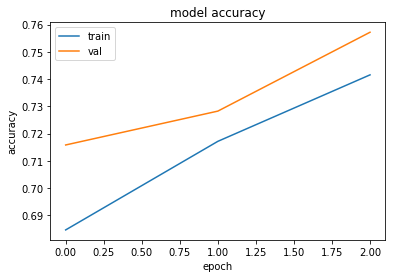

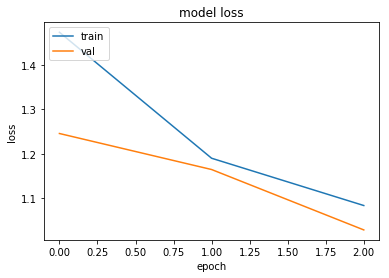

15077/15077 [==============================] - 9s 628us/step
0.8370412203023768 0.8532864628241693
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     10993
           1       0.21      0.72      0.32       323
           2       0.82      0.67      0.74      2680
           3       0.46      0.61      0.53      1081

    accuracy                           0.85     15077
   macro avg       0.62      0.73      0.64     15077
weighted avg       0.90      0.85      0.87     15077

[[10168   335   225   265]
 [   10   231    25    57]
 [  126   296  1803   455]
 [   36   245   137   663]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10960
           1       0.48      0.57      0.52       295
           2       0.86      0.89      0.87      2686
           3       0.69      0.74      0.71      1136

    accuracy                           0.93     15077
   macro avg       0.75      0.79      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10599    40   197   124]
 [   14   167    38    76]
 [   76    49  2391   170]
 [   41    95   164   836]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 200s 4ms/step - loss: 1.4711 - acc: 0.6918 - val_loss: 1.2257 - val_acc: 0.7104
Epoch 2/3
48000/48000 [==============================] - 198s 4ms/step - loss: 1.1913 - acc: 0.7230 - val_loss: 1.1547 - val_acc: 0.7315
Epoch 3/3
48000/48000 [==============================] - 200s 4ms/step - loss: 1.0871 - acc: 0.7427 - val_loss: 1.0444 - val_acc: 0.

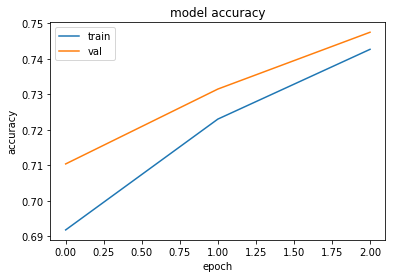

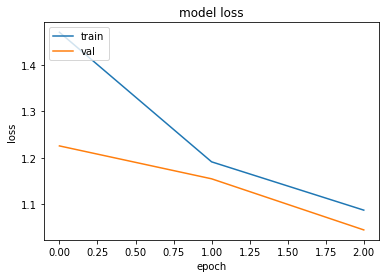

15077/15077 [==============================] - 9s 621us/step
0.8238275161810719 0.8605823439755396
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     10960
           1       0.24      0.62      0.35       295
           2       0.72      0.77      0.74      2686
           3       0.53      0.56      0.54      1136

    accuracy                           0.86     15077
   macro avg       0.62      0.72      0.65     15077
weighted avg       0.89      0.86      0.87     15077

[[10092   184   491   193]
 [   15   184    48    48]
 [  107   202  2068   309]
 [   58   185   262   631]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10985
           1       0.49      0.54      0.51       325
           2       0.86      0.88      0.87      2609
           3       0.69      0.73      0.71      1158

    accuracy                           0.93     15077
   macro avg       0.76      0.78      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10697    19   175    94]
 [   11   174    43    97]
 [   65    61  2302   181]
 [   47    98   168   845]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 196s 4ms/step - loss: 1.4784 - acc: 0.6851 - val_loss: 1.2404 - val_acc: 0.7073
Epoch 2/3
48000/48000 [==============================] - 194s 4ms/step - loss: 1.1870 - acc: 0.7201 - val_loss: 1.1230 - val_acc: 0.7302
Epoch 3/3
48000/48000 [==============================] - 195s 4ms/step - loss: 1.0920 - acc: 0.7400 - val_loss: 1.0192 - val_acc: 0.

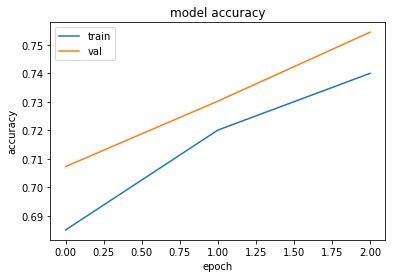

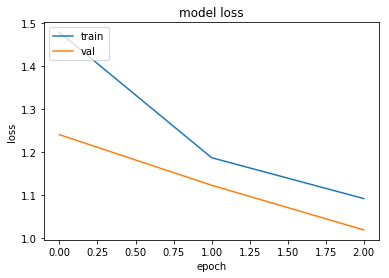

15077/15077 [==============================] - 10s 634us/step
0.791656178157336 0.8680772036877363
              precision    recall  f1-score   support

           0       0.99      0.93      0.96     10985
           1       0.27      0.56      0.37       325
           2       0.74      0.77      0.75      2609
           3       0.52      0.63      0.57      1158

    accuracy                           0.87     15077
   macro avg       0.63      0.72      0.66     15077
weighted avg       0.89      0.87      0.88     15077

[[10181   185   408   211]
 [   14   182    47    82]
 [   94   143  1997   375]
 [   34   161   235   728]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11027
           1       0.50      0.58      0.53       292
           2       0.86      0.88      0.87      2659
           3       0.69      0.76      0.72      1099

    accuracy                           0.93     15077
   macro avg       0.76      0.80      0.78     15077
weighted avg       0.94      0.93      0.93     15077

[[10690    29   205   103]
 [    8   169    35    80]
 [   67    51  2344   197]
 [   36    92   134   837]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 201s 4ms/step - loss: 1.4682 - acc: 0.6866 - val_loss: 1.3475 - val_acc: 0.6853
Epoch 2/3
48000/48000 [==============================] - 227s 5ms/step - loss: 1.1850 - acc: 0.7218 - val_loss: 1.1525 - val_acc: 0.7208
Epoch 3/3
48000/48000 [==============================] - 197s 4ms/step - loss: 1.0883 - acc: 0.7416 - val_loss: 1.0981 - val_acc: 0.

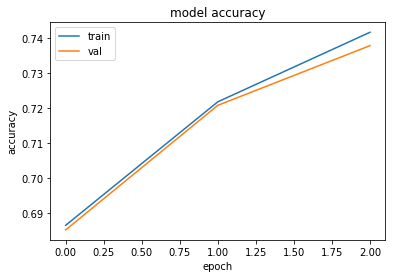

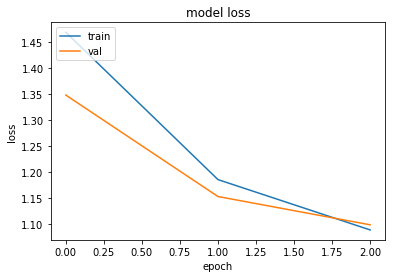

15077/15077 [==============================] - 9s 609us/step
0.804162659307939 0.8686741394255627
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     11027
           1       0.25      0.64      0.36       292
           2       0.75      0.68      0.71      2659
           3       0.56      0.56      0.56      1099

    accuracy                           0.87     15077
   macro avg       0.63      0.71      0.65     15077
weighted avg       0.89      0.87      0.88     15077

[[10487   111   389    40]
 [   23   186    38    45]
 [  209   238  1809   403]
 [   94   213   177   615]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10929
           1       0.49      0.52      0.50       302
           2       0.86      0.88      0.87      2739
           3       0.68      0.75      0.71      1107

    accuracy                           0.93     15077
   macro avg       0.75      0.78      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10606    15   211    97]
 [   10   157    41    94]
 [   62    66  2408   203]
 [   44    84   150   829]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 195s 4ms/step - loss: 1.4663 - acc: 0.6848 - val_loss: 1.2286 - val_acc: 0.7093
Epoch 2/3
48000/48000 [==============================] - 195s 4ms/step - loss: 1.1939 - acc: 0.7200 - val_loss: 1.1048 - val_acc: 0.7382
Epoch 3/3
48000/48000 [==============================] - 196s 4ms/step - loss: 1.0887 - acc: 0.7391 - val_loss: 1.0128 - val_acc: 0.

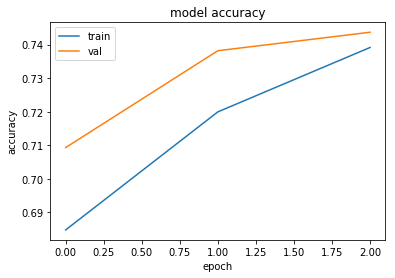

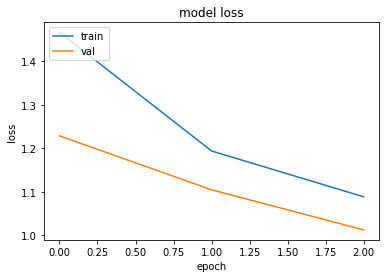

15077/15077 [==============================] - 10s 632us/step
0.7549564390732169 0.8690720965748893
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     10929
           1       0.24      0.72      0.36       302
           2       0.79      0.69      0.74      2739
           3       0.55      0.61      0.57      1107

    accuracy                           0.87     15077
   macro avg       0.64      0.74      0.66     15077
weighted avg       0.90      0.87      0.88     15077

[[10322   167   336   104]
 [   14   216    25    47]
 [  150   290  1894   405]
 [   65   215   156   671]]


In [0]:
# running 5-fold cross validation on tfidf and glove sentence embedding feature
stances = ['unrelated', 'disagree', 'discuss', 'agree']
column_names =  ['Headline', 'Body ID', 'Stance', 'articleBody']
all_data = all_data.sample(frac=1).reset_index(drop=True)
accuracy_scores_rf = []
accuracy_scores_mlp = []
for i in range(5):
  rf = RandomForestClassifier()
  model = build_model(5002)
  kFold_train_df = all_data.iloc[0:0]
  kFold_test_df = all_data.iloc[0:0]
  for j in range(4):
    train_fold = dataset_folds(all_data,((i+j)%5)+1,5)
    kFold_train_df = pd.concat([kFold_train_df,train_fold])
  test_fold = dataset_folds(all_data,((i+4)%5)+1,5)
  kFold_test_df = pd.concat([kFold_test_df,test_fold])
  for stance in stances:
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) == 0):
      continue;              
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) < 15000):
      kFold_train_df = upsample_data(kFold_train_df, str(stance), 15000)
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) > 15000):
      kFold_train_df = downsample_data(kFold_train_df, str(stance), 15000)
  vocab = create_unique_vocabulary(kFold_train_df)
  Xtrain = data_processing_glove_vector(kFold_train_df, 2500, vocab, glove_model)
  Xtest = data_processing_glove_vector(kFold_test_df, 2500, vocab, glove_model)
  Ytrain = kFold_train_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  Ytest = kFold_test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  rf = rf.fit(Xtrain, Ytrain)
  Ypred = rf.predict(Xtest)
  rf_score = accuracy_score(Ytest, Ypred)
  accuracy_scores_rf.append(rf_score)
  print(classification_report(Ytest, Ypred))
  print(confusion_matrix(Ytest, Ypred))
  mlp_score = run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, kFold_test_df)
  accuracy_scores_mlp.append(mlp_score)

In [0]:
from statistics import mean 

print(mean(accuracy_scores_rf))
print(mean(accuracy_scores_mlp))

0.9302646415069311
0.8639384492975795


**Data Processing with Bert** Converting text based representation of data into vector based numerical representations with Bert vector cosine similarity feature

*Skip if using Glove Vectors*

In [0]:
# method to transform the dat from both headline and artileBody in a feature vector for input into the classification model
def data_processing_bert_vector(dataframe, tfidf_vector_size, vocabulary):
  tfidfvectorizer = TfidfVectorizer(max_features = tfidf_vector_size, use_idf=True).fit(vocabulary)# initialise term frequency inverse document frequency vectorizer with vocabulary passed form the unique vocabulary
  transformed_data = []
  for index, row in dataframe.iterrows(): #iterates through every row in the datframe
    headline = row['Headline'] 
    articleBody = row['articleBody']
    head_vec = row['Headline_vector'] # bert headline vector
    article_vec = row['articleBody_vector'] # bert article vector
    cos_vec = cosine_similarity([head_vec], [article_vec]).reshape(1,-1) #find cosine similarity between bert vectors
    headline_tfidf = get_tfidf_vector(tfidfvectorizer, headline) #uses tfidf vectoriser to get a bag of words representation of headline
    articleBody_tfidf = get_tfidf_vector(tfidfvectorizer, articleBody) #uses tfidf vectoriser to get a bag of words representation of article Body
    tfidf_cos = cosine_similarity(headline_tfidf, articleBody_tfidf)
    features = np.squeeze(np.c_[headline_tfidf, articleBody_tfidf, tfidf_cos, cos_vec]) #append all features into a concatenated feature vector
    transformed_data.append(features) #add concatneated feature to data list for input
  transformed_data = np.array(transformed_data) # convert list of data to numpy array
  return transformed_data

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10982
           1       0.49      0.53      0.51       317
           2       0.85      0.89      0.87      2650
           3       0.69      0.73      0.71      1128

    accuracy                           0.93     15077
   macro avg       0.76      0.78      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10685    28   183    86]
 [    5   168    42   102]
 [   63    60  2350   177]
 [   37    85   181   825]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 211s 4ms/step - loss: 1.4700 - acc: 0.6854 - val_loss: 1.2233 - val_acc: 0.7278
Epoch 2/3
48000/48000 [==============================] - 210s 4ms/step - loss: 1.2045 - acc: 0.7185 - val_loss: 1.1308 - val_acc: 0.7326
Epoch 3/3
48000/48000 [==============================] - 209s 4ms/step - loss: 1.1045 - acc: 0.7368 - val_loss: 1.0213 - val_acc: 0.

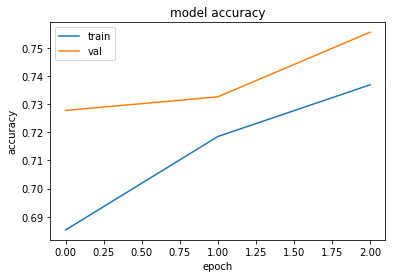

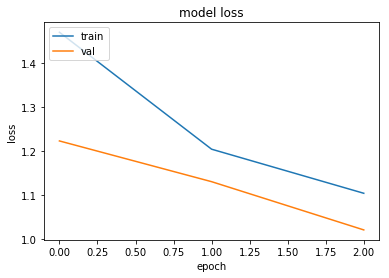

15077/15077 [==============================] - 9s 607us/step
0.8234021507429414 0.8506334151356371
              precision    recall  f1-score   support

           0       0.99      0.93      0.95     10982
           1       0.24      0.72      0.36       317
           2       0.74      0.67      0.70      2650
           3       0.47      0.57      0.51      1128

    accuracy                           0.85     15077
   macro avg       0.61      0.72      0.63     15077
weighted avg       0.89      0.85      0.87     15077

[[10164   235   383   200]
 [    7   228    34    48]
 [  106   265  1786   493]
 [   39   224   218   647]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10982
           1       0.53      0.54      0.53       340
           2       0.87      0.88      0.88      2692
           3       0.69      0.77      0.72      1063

    accuracy                           0.93     15077
   macro avg       0.77      0.79      0.78     15077
weighted avg       0.94      0.93      0.93     15077

[[10700    25   163    94]
 [   12   183    49    96]
 [   82    54  2372   184]
 [   38    83   127   815]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 206s 4ms/step - loss: 1.4730 - acc: 0.6885 - val_loss: 1.2902 - val_acc: 0.7013
Epoch 2/3
48000/48000 [==============================] - 204s 4ms/step - loss: 1.2016 - acc: 0.7209 - val_loss: 1.1543 - val_acc: 0.7364
Epoch 3/3
48000/48000 [==============================] - 204s 4ms/step - loss: 1.0916 - acc: 0.7409 - val_loss: 1.0630 - val_acc: 0.

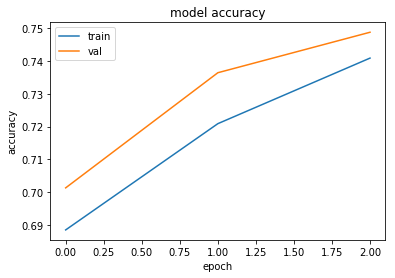

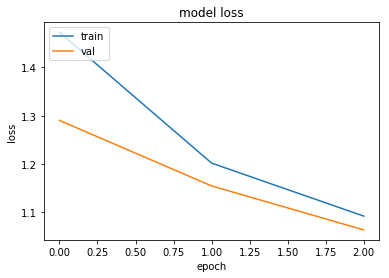

15077/15077 [==============================] - 10s 654us/step
0.8707827751537038 0.8431385554234403
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     10982
           1       0.23      0.77      0.35       340
           2       0.78      0.63      0.69      2692
           3       0.44      0.62      0.51      1063

    accuracy                           0.84     15077
   macro avg       0.61      0.73      0.63     15077
weighted avg       0.89      0.84      0.86     15077

[[10106   271   337   268]
 [   15   262    18    45]
 [   93   376  1687   536]
 [   30   249   127   657]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     11105
           1       0.48      0.55      0.52       271
           2       0.86      0.89      0.87      2639
           3       0.70      0.75      0.72      1062

    accuracy                           0.93     15077
   macro avg       0.76      0.79      0.77     15077
weighted avg       0.94      0.93      0.94     15077

[[10787    19   193   106]
 [    9   150    49    63]
 [   66    52  2342   179]
 [   43    90   133   796]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 211s 4ms/step - loss: 1.4684 - acc: 0.6872 - val_loss: 1.3302 - val_acc: 0.6977
Epoch 2/3
48000/48000 [==============================] - 210s 4ms/step - loss: 1.1928 - acc: 0.7203 - val_loss: 1.1064 - val_acc: 0.7266
Epoch 3/3
48000/48000 [==============================] - 210s 4ms/step - loss: 1.0955 - acc: 0.7398 - val_loss: 1.0219 - val_acc: 0.

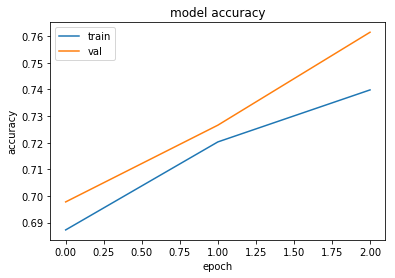

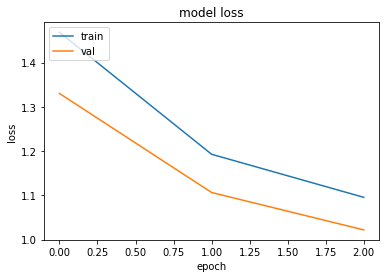

15077/15077 [==============================] - 9s 611us/step
0.7738134623751951 0.8784240896730119
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     11105
           1       0.23      0.73      0.35       271
           2       0.82      0.69      0.75      2639
           3       0.53      0.58      0.55      1062

    accuracy                           0.88     15077
   macro avg       0.64      0.74      0.65     15077
weighted avg       0.91      0.88      0.89     15077

[[10600   154   184   167]
 [    9   198    31    33]
 [  167   291  1831   350]
 [   33   231   183   615]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10903
           1       0.49      0.58      0.53       303
           2       0.86      0.88      0.87      2700
           3       0.69      0.75      0.71      1171

    accuracy                           0.93     15077
   macro avg       0.75      0.79      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10559    28   191   125]
 [    7   176    34    86]
 [   78    67  2365   190]
 [   42    90   166   873]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 197s 4ms/step - loss: 1.4717 - acc: 0.6826 - val_loss: 1.2185 - val_acc: 0.7167
Epoch 2/3
48000/48000 [==============================] - 196s 4ms/step - loss: 1.2025 - acc: 0.7190 - val_loss: 1.1657 - val_acc: 0.7396
Epoch 3/3
48000/48000 [==============================] - 194s 4ms/step - loss: 1.0949 - acc: 0.7398 - val_loss: 1.0653 - val_acc: 0.

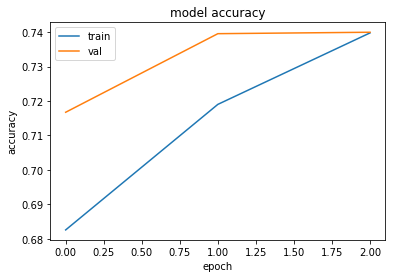

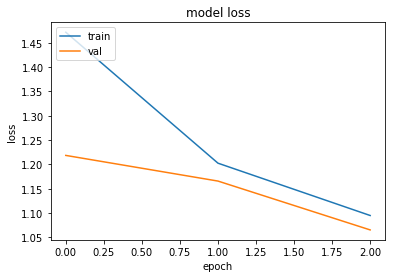

15077/15077 [==============================] - 9s 599us/step
0.7722397139140891 0.8728526895270943
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10903
           1       0.26      0.72      0.38       303
           2       0.82      0.66      0.73      2700
           3       0.53      0.57      0.55      1171

    accuracy                           0.87     15077
   macro avg       0.64      0.73      0.66     15077
weighted avg       0.90      0.87      0.88     15077

[[10500   126   186    91]
 [   12   217    18    56]
 [  204   267  1770   459]
 [   84   235   179   673]]


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      0.97      0.98     10922
           1       0.44      0.54      0.48       306
           2       0.87      0.88      0.87      2692
           3       0.70      0.77      0.73      1157

    accuracy                           0.93     15077
   macro avg       0.75      0.79      0.77     15077
weighted avg       0.93      0.93      0.93     15077

[[10564    53   187   118]
 [   12   165    37    92]
 [   79    68  2367   178]
 [   37    89   143   888]]
Train on 48000 samples, validate on 12000 samples
Epoch 1/3
48000/48000 [==============================] - 194s 4ms/step - loss: 1.4749 - acc: 0.6880 - val_loss: 1.2310 - val_acc: 0.6920
Epoch 2/3
48000/48000 [==============================] - 192s 4ms/step - loss: 1.1939 - acc: 0.7224 - val_loss: 1.1457 - val_acc: 0.7230
Epoch 3/3
48000/48000 [==============================] - 195s 4ms/step - loss: 1.0899 - acc: 0.7429 - val_loss: 1.0405 - val_acc: 0.

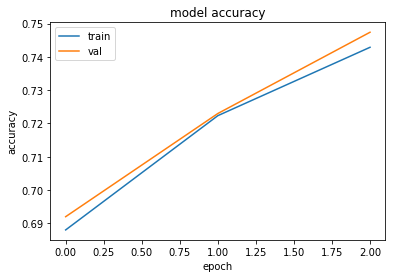

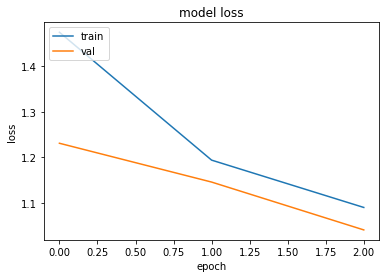

15077/15077 [==============================] - 9s 598us/step
0.7376804769122174 0.8839954898228829
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     10922
           1       0.26      0.74      0.38       306
           2       0.81      0.71      0.76      2692
           3       0.64      0.49      0.56      1157

    accuracy                           0.88     15077
   macro avg       0.67      0.73      0.67     15077
weighted avg       0.90      0.88      0.89     15077

[[10608   104   163    47]
 [   26   226    29    25]
 [  228   294  1922   248]
 [   76   254   255   572]]


In [0]:
# running 5-fold cross validation on tfidf and glove sentence embedding feature
stances = ['unrelated', 'disagree', 'discuss', 'agree']
column_names =  ['Headline', 'Body ID', 'Stance', 'articleBody']
all_data = all_data.sample(frac=1).reset_index(drop=True)
accuracy_scores_rf_bert = []
accuracy_scores_mlp_bert = []
for i in range(5):
  rf = RandomForestClassifier()
  model = build_model(5002)
  kFold_train_df = all_data.iloc[0:0]
  kFold_test_df = all_data.iloc[0:0]
  for j in range(4):
    train_fold = dataset_folds(all_data,((i+j)%5)+1,5)
    kFold_train_df = pd.concat([kFold_train_df,train_fold])
  test_fold = dataset_folds(all_data,((i+4)%5)+1,5)
  kFold_test_df = pd.concat([kFold_test_df,test_fold])
  for stance in stances:
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) == 0):
      continue;              
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) < 15000):
      kFold_train_df = upsample_data(kFold_train_df, str(stance), 15000)
    if (len(kFold_train_df[kFold_train_df['Stance'] == str(stance)]) > 15000):
      kFold_train_df = downsample_data(kFold_train_df, str(stance), 15000)
  vocab = create_unique_vocabulary(kFold_train_df)
  Xtrain = data_processing_bert_vector(kFold_train_df, 2500, vocab)
  Xtest = data_processing_bert_vector(kFold_test_df, 2500, vocab)
  Ytrain = kFold_train_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  Ytest = kFold_test_df.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss': 2, 'agree': 3})
  rf = rf.fit(Xtrain, Ytrain)
  Ypred = rf.predict(Xtest)
  rf_score = accuracy_score(Ytest, Ypred)
  accuracy_scores_rf_bert.append(rf_score)
  print(classification_report(Ytest, Ypred))
  print(confusion_matrix(Ytest, Ypred))
  mlp_score = run_MLP(model, Xtrain, Xtest, Ytrain, Ytest, kFold_test_df)
  accuracy_scores_mlp_bert.append(mlp_score)

In [0]:
from statistics import mean 

print(mean(accuracy_scores_rf_bert))
print(mean(accuracy_scores_mlp_bert))

0.9302911719838164
0.8658088479164133
